<a href="https://colab.research.google.com/github/mohammadreza-mohammadi94/Deep-Learning-CNN-Projects/blob/master/EuroSat-Classification-ResNet-Modell/euro_sat_classification_resnet_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50V2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess_input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.layers import (Dense,
                                     GlobalAveragePooling2D,
                                     Input,
                                     Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import pathlib

# Load Dataset

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    "/kaggle/input/eurosat-dataset/EuroSAT",
    subset="training",
    validation_split=0.2,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

val_ds = image_dataset_from_directory(
    "/kaggle/input/eurosat-dataset/EuroSAT",
    subset="validation",
    validation_split=0.2,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.


I0000 00:00:1764760645.060196      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764760645.060884      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


# Check Samples

In [ ]:
import numpy as np

class_names = train_ds.class_names
num_classes = len(class_names)

# Initialize dictionaries to store counts
train_class_counts = {name: 0 for name in class_names}
val_class_counts = {name: 0 for name in class_names}

print("Counting samples in training dataset...")
for _, labels in train_ds:
    for label in labels.numpy():
        train_class_counts[class_names[label]] += 1

print("Counting samples in validation dataset...")
for _, labels in val_ds:
    for label in labels.numpy():
        val_class_counts[class_names[label]] += 1

print("\n--- Samples per class in Training Dataset ---")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} samples")

print("\n--- Samples per class in Validation Dataset ---")
for class_name, count in val_class_counts.items():
    print(f"{class_name}: {count} samples")

Counting samples in training dataset...
Counting samples in validation dataset...

--- Samples per class in Training Dataset ---
AnnualCrop: 2441 samples
Forest: 2386 samples
HerbaceousVegetation: 2411 samples
Highway: 2001 samples
Industrial: 2012 samples
Pasture: 1607 samples
PermanentCrop: 1971 samples
Residential: 2363 samples
River: 2009 samples
SeaLake: 2399 samples

--- Samples per class in Validation Dataset ---
AnnualCrop: 559 samples
Forest: 614 samples
HerbaceousVegetation: 589 samples
Highway: 499 samples
Industrial: 488 samples
Pasture: 393 samples
PermanentCrop: 529 samples
Residential: 637 samples
River: 491 samples
SeaLake: 601 samples


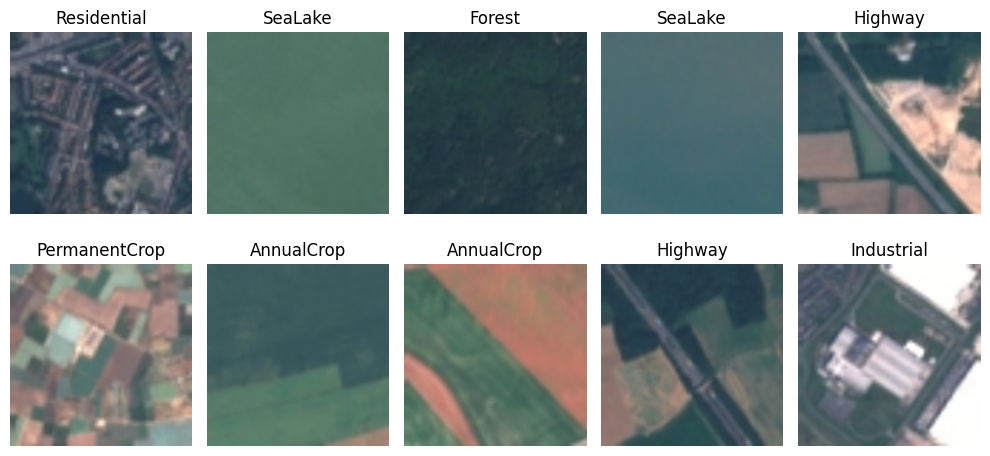

In [ ]:
# Plot samples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
for images, labels in train_ds.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

# Prepare `ResNet`

In [ ]:
train_ds = train_ds.map(lambda x, y: (resnet_preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (resnet_preprocess_input(x), y))

# Config
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Load ResNet

In [ ]:
resnet_base_model = ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SIZE + (3,)
)

# Set trainable to False
resnet_base_model.trainable=False
resnet_base_model.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

## Adding New Heads

In [ ]:
def build_resnet(base_model, num_classes):
    l2_reg = tf.keras.regularizers.l2(0.001)
    inputs = Input(shape=(*IMAGE_SIZE, 3), name="input_layer")
    x = resnet_base_model(inputs, training=False)
    x = GlobalAveragePooling2D(name="gap_layer")(x)
    x = Dropout(0.4, name="dropout_gap")(x)
    x = Dense(
        1024,
        name="dense_layer",
        kernel_regularizer=l2_reg)(x)
    x = Dropout(
        0.5, name="dropout_hidden_layer")(x)
    outputs = Dense(
        num_classes, activation="softmax",
        name="output_layer", kernel_regularizer=l2_reg)(x)
    return Model(inputs, outputs)

resnet_model = build_resnet(resnet_base_model, num_classes)
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gap_layer                       │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_gap (Dropout)           │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer (Dense)             │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_hidden_layer (Dropout)  │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,673,226 (97.94 MB)

 Trainable params: 24,180,746 (92.24 MB)

 Non-trainable params: 1,492,480 (5.69 MB)

## Training

In [ ]:
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Training Phase
INITIAL_EPOCHS = 5
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True),

    ModelCheckpoint(
        filepath="model.keras",
        monitor="val_loss",
        save_best_only=True)
]

history_head_resnet = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INITIAL_EPOCHS,
    callbacks=callbacks
)

Epoch 1/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 164s 201ms/step - accuracy: 0.7267 - loss: 2.0774 - val_accuracy: 0.8446 - val_loss: 1.0080
Epoch 2/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 134s 198ms/step - accuracy: 0.8649 - loss: 0.8347 - val_accuracy: 0.9187 - val_loss: 0.4502
Epoch 3/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 132s 196ms/step - accuracy: 0.9241 - loss: 0.4171 - val_accuracy: 0.9391 - val_loss: 0.3107
Epoch 4/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 133s 197ms/step - accuracy: 0.9389 - loss: 0.2938 - val_accuracy: 0.9391 - val_loss: 0.2853
Epoch 5/5
675/675 ━━━━━━━━━━━━━━━━━━━━ 131s 195ms/step - accuracy: 0.9494 - loss: 0.2385 - val_accuracy: 0.9356 - val_loss: 0.3211


## Fine Tuning

In [ ]:
FINE_TUNE_LR = 5e-6

resnet_base_model.trainable = True

# Determine the Freeze Point (Up to the start of Conv4 Block)
# This layer is the first Conv layer in the 4th Convolutional Block (conv4_block1_1_conv)
FINE_TUNE_START_LAYER_NAME = 'conv5_block1_1_conv'

freeze_until_layer_index = 0
for i, layer in enumerate(resnet_base_model.layers):
    if layer.name == FINE_TUNE_START_LAYER_NAME:
        freeze_until_layer_index = i
        break

# Freeze the early layers (Conv1, Conv2, Conv3)
for layer in resnet_base_model.layers[:freeze_until_layer_index]:
    layer.trainable = False

print(f"ResNet50 layers frozen up to index: {freeze_until_layer_index} (Freezing Conv1, Conv2, Conv3).")
print(f"Layers now trainable (Fine-Tuning): {len(resnet_base_model.layers) - freeze_until_layer_index} layers + Head.")


# Recompile with the Very Small Learning Rate (CRUCIAL STEP)
# The optimizer graph is rebuilt, incorporating the newly unfrozen weights.
resnet_model.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LR),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train for additional epochs
fine_tune_epochs = 10
total_epochs = INITIAL_EPOCHS + fine_tune_epochs

print(f"Starting Fine-Tuning for {fine_tune_epochs} epochs at LR={FINE_TUNE_LR}")

history_ft = resnet_model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history_head_resnet.epoch[-1], # Continue training from the last epoch of Phase 1
    validation_data=val_ds,
    callbacks=callbacks)


ResNet50 layers frozen up to index: 156 (Freezing Conv1, Conv2, Conv3).
Layers now trainable (Fine-Tuning): 34 layers + Head.
Starting Fine-Tuning for 10 epochs at LR=5e-06
Epoch 5/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 117s 149ms/step - accuracy: 0.9525 - loss: 0.2348 - val_accuracy: 0.9557 - val_loss: 0.2227
Epoch 6/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 96s 142ms/step - accuracy: 0.9605 - loss: 0.1992 - val_accuracy: 0.9563 - val_loss: 0.2059
Epoch 7/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 95s 141ms/step - accuracy: 0.9629 - loss: 0.1840 - val_accuracy: 0.9578 - val_loss: 0.1967
Epoch 8/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 95s 141ms/step - accuracy: 0.9653 - loss: 0.1751 - val_accuracy: 0.9589 - val_loss: 0.1907
Epoch 9/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 95s 141ms/step - accuracy: 0.9667 - loss: 0.1724 - val_accuracy: 0.9600 - val_loss: 0.1858
Epoch 10/15
675/675 ━━━━━━━━━━━━━━━━━━━━ 95s 141ms/step - accuracy: 0.9674 - loss: 0.1691 - val_accuracy: 0.9620 - val_loss: 0.1817
Epoch 11/15
675/675 ━━━━━━━━━━━━━━━━━━━

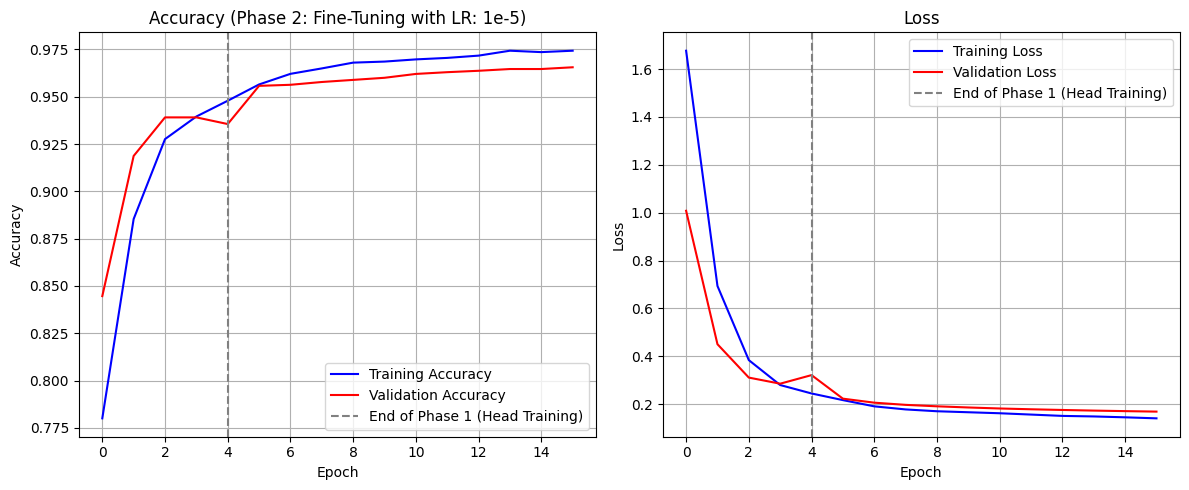

In [ ]:
def plot_fine_tuning_curves(history_head, history_ft, initial_epochs):

    # Combine history from both phases
    acc = history_head.history['accuracy'] + history_ft.history['accuracy']
    val_acc = history_head.history['val_accuracy'] + history_ft.history['val_accuracy']
    loss = history_head.history['loss'] + history_ft.history['loss']
    val_loss = history_head.history['val_loss'] + history_ft.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # 1. Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
    plt.axvline(x=initial_epochs - 1, color='gray', linestyle='--', label='End of Phase 1 (Head Training)')
    plt.legend(loc='lower right')
    plt.title('Accuracy (Phase 2: Fine-Tuning with LR: 1e-5)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    # 2. Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue')
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')
    plt.axvline(x=initial_epochs - 1, color='gray', linestyle='--', label='End of Phase 1 (Head Training)')
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_fine_tuning_curves(history_head_resnet, history_ft, INITIAL_EPOCHS)